In [1]:
import pandas as pd
import numpy as np
import nilearn as nil
import glob as glob
import matplotlib.pyplot as plt

from nilearn import image

In [2]:
MAX = image.load_img("/data/bswift-1/Pessoa_Lab/MAX/ROI_masks/MAX_ROIs_final_gm_85.nii.gz")

amyg_dict = {"R_CeMe_Amyg": 56, "L_CeMe_Amyg" : 57, 
             "R_BLBM_Amyg": 58, "L_BLBM_Amyg" : 59}

left_amyg = MAX.get_fdata().copy()
right_amyg = MAX.get_fdata().copy()

left_amyg[np.where((MAX.get_fdata() != amyg_dict["L_CeMe_Amyg"]) & 
                   (MAX.get_fdata() != amyg_dict["L_BLBM_Amyg"]))] = 0

right_amyg[np.where((MAX.get_fdata() != amyg_dict["R_CeMe_Amyg"]) & 
                   (MAX.get_fdata() != amyg_dict["R_BLBM_Amyg"]))] = 0

In [3]:
for roi, idx in amyg_dict.items():
    num_vox = np.where(left_amyg + right_amyg == idx)[0].shape[0]
    print('Number of voxels in {roi} is {num_vox}'.format(roi = roi, num_vox = int(num_vox)))

Number of voxels in R_CeMe_Amyg is 47
Number of voxels in L_CeMe_Amyg is 35
Number of voxels in R_BLBM_Amyg is 129
Number of voxels in L_BLBM_Amyg is 132


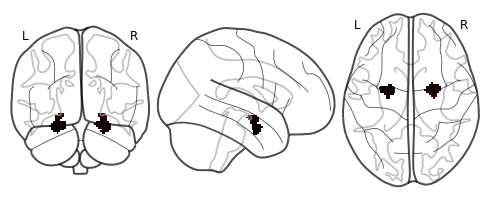

In [5]:
from nilearn.plotting import plot_glass_brain

plot_glass_brain(image.new_img_like(MAX, left_amyg + right_amyg))

In [6]:
def roi_partition(roi, hem, start, num):
    
    idx = np.where(roi == hem)
    df_idx = pd.DataFrame(idx).transpose()
    temp = roi.copy()
    
    if num == 1:
        temp[idx] = start
    else:
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=num, max_iter=10000, random_state=20210607)
        kmeans.fit(df_idx)
    
        df_idx['label'] = kmeans.labels_ + start
    
        for _ , row in df_idx.iterrows():
            temp[row[0], row[1], row[2]] = row['label']
        
    return temp

In [7]:
# in order to combine with left/right insula, the index of left/right amygdala will start
# with the end of left/right insula index

left_amyg = roi_partition(left_amyg, 57, 12, 1)
left_amyg = roi_partition(left_amyg, 59, 13, 5)

right_amyg = roi_partition(right_amyg, 56, 11, 1)
right_amyg = roi_partition(right_amyg, 58, 12, 5)

In [10]:
def print_subROIs(mask, hem):
    cluster = np.unique(mask)[1:]
    print("For " + hem + " Amygdala:")
    for i in cluster:
        num = np.where(mask == i)[0].shape[0]
        print('number of voxels in sub-ROI {0} is {1}'.format(int(i), num))

In [11]:
print_subROIs(left_amyg, "left")

For left Amygdala:
number of voxels in sub-ROI 12 is 35
number of voxels in sub-ROI 13 is 29
number of voxels in sub-ROI 14 is 16
number of voxels in sub-ROI 15 is 31
number of voxels in sub-ROI 16 is 25
number of voxels in sub-ROI 17 is 31


In [12]:
print_subROIs(right_amyg, "right")

For right Amygdala:
number of voxels in sub-ROI 11 is 47
number of voxels in sub-ROI 12 is 26
number of voxels in sub-ROI 13 is 30
number of voxels in sub-ROI 14 is 26
number of voxels in sub-ROI 15 is 23
number of voxels in sub-ROI 16 is 24


In [13]:
# display subROIs in 3D
import plotly.express as px

def plot_subROIs(mask):
    x, y, z = np.where(mask != 0)
    label = mask[x, y, z]
    
    df = pd.DataFrame({'x': x, 'y':y, 'z':z, 'label':label})
    fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', color = 'label')
    
    return(fig)

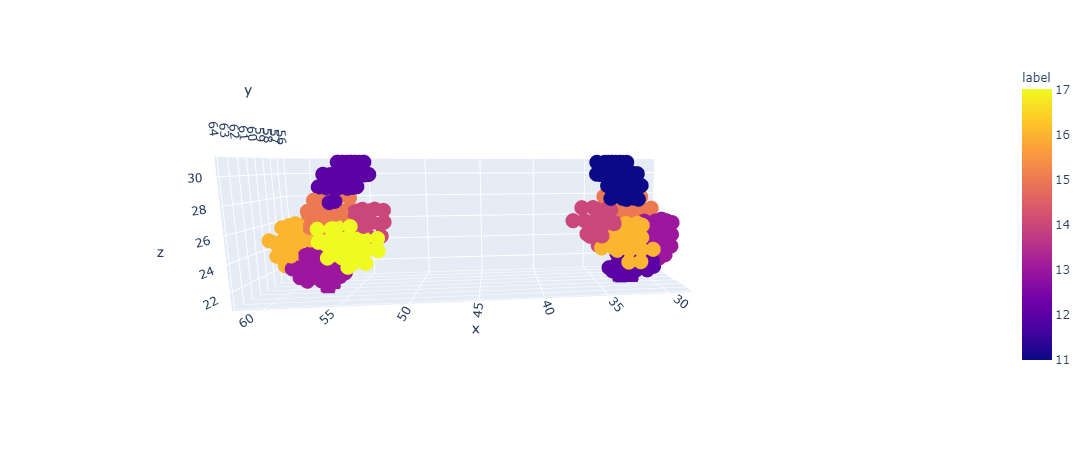

In [16]:
plot_subROIs(left_amyg + right_amyg)

# Combine left/right insula mask with left/right amygdala mask

In [17]:
left_insula = image.load_img('data/left_insula_11ROIs.nii.gz')
right_insula = image.load_img('data/right_insula_10ROIs.nii.gz')

In [27]:
left = left_insula.get_fdata() + left_amyg
right = right_insula.get_fdata() + right_amyg

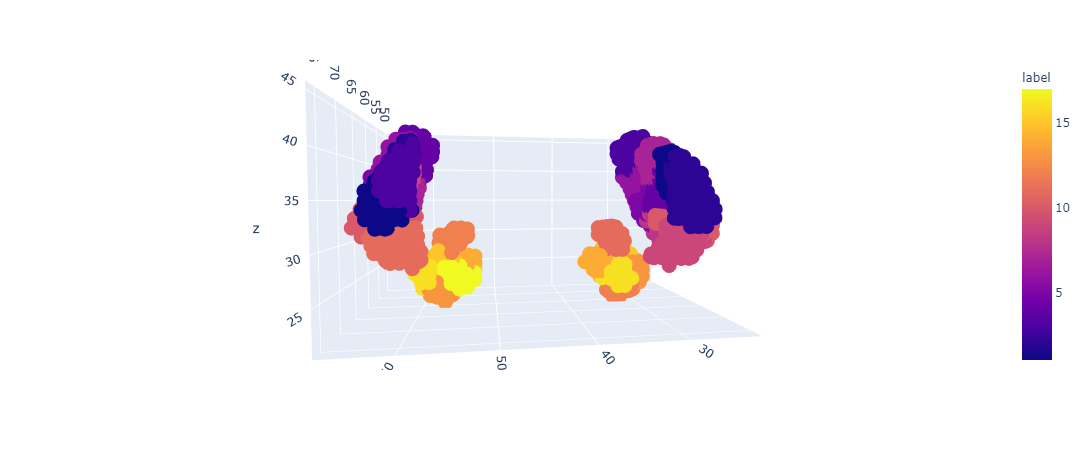

In [31]:
plot_subROIs(left + right)

In [ ]:
image.new_img_like(left_insula, left).to_filename("data/left_17ROIs.nii.gz")
image.new_img_like(right_insula, right).to_filename("data/right_16ROIs.nii.gz")